In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
# from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf

In [2]:
# uncomment to disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 2 Logical GPUs


# Case 1

10.0

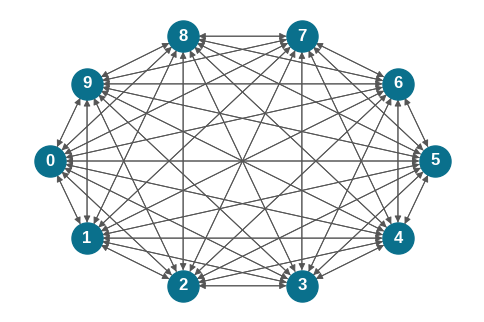

In [3]:
graph_1, edge_list_1, node_list_1 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)

# nx.draw(graph, with_labels=True, pos=nx.shell_layout(graph) , font_weight='bold', ax=ax, **options)
maxentep.draw_graph(graph_1, dpi =100)
dof_1 = maxentep.graph_dof(graph_1.edges(), node_list_1)
dof_1

Reference Model

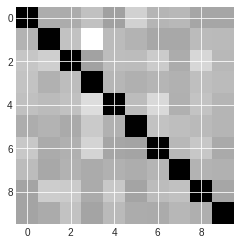

In [5]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
# mobility_matrix[1,:]= 0
# mobility_matrix[:,1]= 0
mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(mobility_matrix, mobility_matrix_diag)
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(mobility_matrix))
# np.diagonal(mobility_matrix)
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


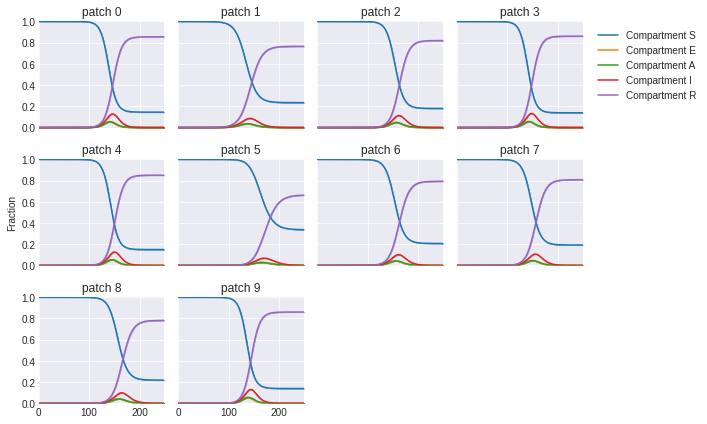

In [8]:
def gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, mobility_matrix=mobility_matrix, population=None, area= None):
    tmat = maxentep.TransitionMatrix(compartments, [1,2])
#     eta = 1/2
#     alpha = 1/2
#     mu = 1/5
    tmat.add_transition('E', 'A', 1/eta, 0)
    tmat.add_transition('A', 'I', 1/alpha, 0)
    tmat.add_transition('I', 'R', 1/mu, 0)
    infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
#     timesteps = 250
    model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

    # starting fractions probabilities
    start = np.zeros((M,C)) #anywhere
    # Assume starting from Node 1
    initial_exposed = 1/population[1]
    start[1,0] = initial_exposed
    # start[0,0] = 0.05
#     beta = 0.03
    mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
    ref_traj = model(mobility_matrix_norm, tmat.value, start, np.array([beta,beta]))[0]
    ref_traj = ref_traj[tf.newaxis, ...]
    return ref_traj
ref_traj_1 = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, population=population,
                          area=area, mobility_matrix=mobility_matrix)
maxentep.patch_quantile(ref_traj_1, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Add Restraints

Restraints are set in this time range: [0, 180]
122 0.015657699 0.033452784933028494
73 3.4974764e-05 0.0
45 8.8457455e-07 0.007945232507257174
108 0.0028866048 0.014423558763083542
3 1.16722534e-11 0.0
115 0.010361445 0.04895208621270799
66 2.0206053e-05 0.01900862219131062
24 4.189118e-08 0.0017510667188841203
17 1.0552815e-08 0.0
38 2.9669027e-07 0.01716505239736926
171 0.030818868 0.032705554227992546
45 7.9880334e-07 0.0
101 0.0019340854 0.0011484290259806147
129 0.06601219 0.04265031883740475
66 1.9099152e-05 0.010484632362903683
17 8.088455e-09 0.0
122 0.004820835 0.05808538614199958
157 0.10557673 0.11378252061324903
31 6.046643e-08 0.009713098335794722
17 6.7200525e-09 0.02623053766147473
59 3.513909e-06 0.0
3 6.451803e-12 0.0
171 0.58774346 0.5720417305037842
136 0.038945805 0.0068399239508460385
3 1.8099601e-10 0.0
129 0.04977252 0.058093520543501295
52 3.4130649e-06 0.0
38 5.0210986e-07 0.015624464144055784
108 0.006730086 0.026914976788428056
143 0.32328823 0.3375560234984

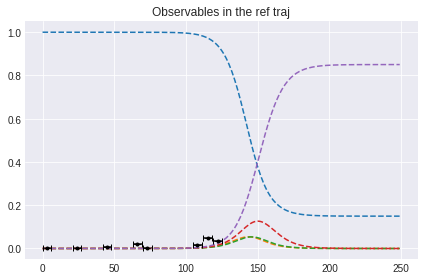

In [9]:
npoints = 4
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
def gen_restraints(ref_traj):
    prior = maxentep.EmptyPrior()

    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    # Visualizing restraints
    restrained_patch = restrained_patches[0]
    restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.02, start_time=0, end_time=180)
    plt.plot(ref_traj[0,:,restrained_patch,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[0]):
        pf(plt.gca(), 0)
    plt.title('Observables in the ref traj')
    plt.tight_layout()
    return restraints, plot_fxns_list, restrained_patches
restraints_1, plot_fxns_list_1, restrained_patches_1 = gen_restraints(ref_traj_1)

# Sample

In [10]:
def gen_samples(mobility_matrix, timesteps =250, area = area, populations = population):
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 1, 1)
    tmat.add_transition('A', 'I', 3, 1)
    tmat.add_transition('I', 'R', 7, 2)
    hyper_pram = maxentep.ParameterHypers()
    hyper_pram.beta_low = [0.005]*2
    hyper_pram.beta_high = [0.05]*2
    hyper_pram.beta_var = [0.03]*2
    hyper_pram.start_high = 2e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 4e-6
    start_logits = np.zeros((M))
    param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',hypers = hyper_pram, n_infectious_compartments=2)
    import tqdm
    N = 512
    batches = 16
    total_batches = N * batches
    outs = []
    infect = maxentep.contact_infection_func(infections_compartments, area = area)
    model = maxentep.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    param_batch = prior_prams[0]
    mask = tf.greater(param_batch[2], 0)
    start_exposed_dist = tf.boolean_mask(param_batch[2], mask).numpy()
    # prior_param_dist = maxentep.get_dist(prior_prams)
    # maxentep.plot_dist(*prior_param_dist)
    return trajs
trajs_1 = gen_samples(mobility_matrix, timesteps =250, area = area, populations = population)

100%|██████████| 16/16 [00:33<00:00,  2.12s/it]


<AxesSubplot:ylabel='Count'>

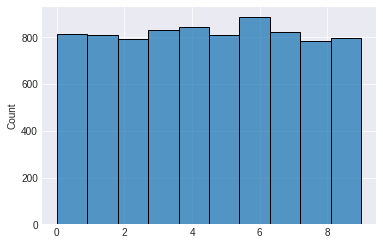

In [11]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
# print(np.where(prior_exposed_patch==0))
sns.histplot(x=prior_exposed_patch_1, label='Prior',
            color='C0',bins=M)

In [12]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments] and compares to a ref_traj
    '''
#     weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.06)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()

Plotting 10 patches in a 3 x 4 grid


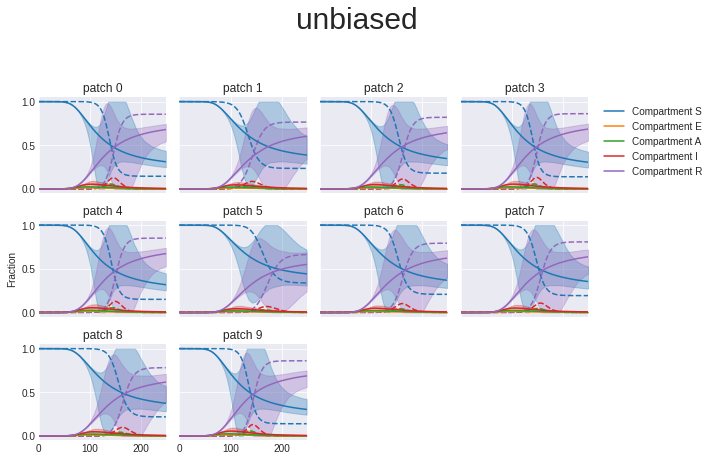

In [13]:
compare_to_ref(ref_traj_1,trajs_1, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

# Applying MaxEnt

Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0086 - weight-entropy: 6.9216
Epoch 2/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0050 - weight-entropy: 6.8718
Epoch 3/500
8/8 [==============================] - 0s 989us/step - loss: 0.0042 - weight-entropy: 6.8176
Epoch 4/500
8/8 [==============================] - 0s 979us/step - loss: 0.0041 - weight-entropy: 6.7856
Epoch 5/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0041 - weight-entropy: 6.7750
Epoch 6/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0040 - weight-entropy: 6.7768
Epoch 7/500
8/8 [==============================] - 0s 998us/step - loss: 0.0039 - weight-entropy: 6.7841
Epoch 8/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0038 - weight-entropy: 6.7910
Epoch 9/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0037 - weight-entropy: 6.7948
Epoch 10/500
8/8 [==============================] - 0s 1ms/step - l

8/8 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 6.2893
Epoch 80/500
8/8 [==============================] - 0s 998us/step - loss: 0.0018 - weight-entropy: 6.2820
Epoch 81/500
8/8 [==============================] - 0s 989us/step - loss: 0.0018 - weight-entropy: 6.2734
Epoch 82/500
8/8 [==============================] - 0s 972us/step - loss: 0.0018 - weight-entropy: 6.2656
Epoch 83/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 6.2575
Epoch 84/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 6.2500
Epoch 85/500
8/8 [==============================] - 0s 979us/step - loss: 0.0018 - weight-entropy: 6.2451
Epoch 86/500
8/8 [==============================] - 0s 966us/step - loss: 0.0018 - weight-entropy: 6.2346
Epoch 87/500
8/8 [==============================] - 0s 962us/step - loss: 0.0018 - weight-entropy: 6.2280
Epoch 88/500
8/8 [==============================] - 0s 959us/step

8/8 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 5.7796
Epoch 157/500
8/8 [==============================] - 0s 962us/step - loss: 0.0014 - weight-entropy: 5.7735
Epoch 158/500
8/8 [==============================] - 0s 987us/step - loss: 0.0014 - weight-entropy: 5.7792
Epoch 159/500
8/8 [==============================] - 0s 988us/step - loss: 0.0014 - weight-entropy: 5.7665
Epoch 160/500
8/8 [==============================] - 0s 980us/step - loss: 0.0014 - weight-entropy: 5.7615
Epoch 161/500
8/8 [==============================] - 0s 966us/step - loss: 0.0014 - weight-entropy: 5.7529
Epoch 162/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 5.7470
Epoch 163/500
8/8 [==============================] - 0s 930us/step - loss: 0.0014 - weight-entropy: 5.7384
Epoch 164/500
8/8 [==============================] - 0s 939us/step - loss: 0.0014 - weight-entropy: 5.7340
Epoch 165/500
8/8 [==============================] - 0s

8/8 [==============================] - 0s 981us/step - loss: 0.0012 - weight-entropy: 5.4757
Epoch 234/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 5.4454
Epoch 235/500
8/8 [==============================] - 0s 995us/step - loss: 0.0011 - weight-entropy: 5.4346
Epoch 236/500
8/8 [==============================] - 0s 986us/step - loss: 0.0011 - weight-entropy: 5.4374
Epoch 237/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 5.4358
Epoch 238/500
8/8 [==============================] - 0s 951us/step - loss: 0.0011 - weight-entropy: 5.4400
Epoch 239/500
8/8 [==============================] - 0s 981us/step - loss: 0.0011 - weight-entropy: 5.4296
Epoch 240/500
8/8 [==============================] - 0s 981us/step - loss: 0.0011 - weight-entropy: 5.4185
Epoch 241/500
8/8 [==============================] - 0s 977us/step - loss: 0.0011 - weight-entropy: 5.4208
Epoch 242/500
8/8 [==============================] - 0s

8/8 [==============================] - 0s 1ms/step - loss: 9.0096e-04 - weight-entropy: 5.1953
Epoch 310/500
8/8 [==============================] - 0s 1ms/step - loss: 8.5085e-04 - weight-entropy: 5.1585
Epoch 311/500
8/8 [==============================] - 0s 1ms/step - loss: 8.2216e-04 - weight-entropy: 5.1464
Epoch 312/500
8/8 [==============================] - 0s 1ms/step - loss: 8.1422e-04 - weight-entropy: 5.1632
Epoch 313/500
8/8 [==============================] - 0s 1ms/step - loss: 8.0856e-04 - weight-entropy: 5.1660
Epoch 314/500
8/8 [==============================] - 0s 1ms/step - loss: 7.9068e-04 - weight-entropy: 5.1411
Epoch 315/500
8/8 [==============================] - 0s 1ms/step - loss: 8.7097e-04 - weight-entropy: 5.1613
Epoch 316/500
8/8 [==============================] - 0s 1ms/step - loss: 7.9157e-04 - weight-entropy: 5.1540
Epoch 317/500
8/8 [==============================] - 0s 1ms/step - loss: 8.3087e-04 - weight-entropy: 5.1631
Epoch 318/500
8/8 [==============

8/8 [==============================] - 0s 978us/step - loss: 7.1545e-04 - weight-entropy: 4.9664
Epoch 384/500
8/8 [==============================] - 0s 994us/step - loss: 6.9000e-04 - weight-entropy: 4.9763
Epoch 385/500
8/8 [==============================] - 0s 1ms/step - loss: 6.9552e-04 - weight-entropy: 4.9818
Epoch 386/500
8/8 [==============================] - 0s 982us/step - loss: 7.1759e-04 - weight-entropy: 4.9727
Epoch 387/500
8/8 [==============================] - 0s 961us/step - loss: 7.6301e-04 - weight-entropy: 5.0261
Epoch 388/500
8/8 [==============================] - 0s 1ms/step - loss: 6.6743e-04 - weight-entropy: 4.9628
Epoch 389/500
8/8 [==============================] - 0s 997us/step - loss: 6.3776e-04 - weight-entropy: 4.9495
Epoch 390/500
8/8 [==============================] - 0s 1ms/step - loss: 7.4524e-04 - weight-entropy: 4.9810
Epoch 391/500
8/8 [==============================] - 0s 1ms/step - loss: 6.9861e-04 - weight-entropy: 4.9467
Epoch 392/500
8/8 [====

8/8 [==============================] - 0s 982us/step - loss: 6.8089e-04 - weight-entropy: 4.9334
Epoch 458/500
8/8 [==============================] - 0s 995us/step - loss: 6.9771e-04 - weight-entropy: 4.9203
Epoch 459/500
8/8 [==============================] - 0s 974us/step - loss: 6.5383e-04 - weight-entropy: 4.8894
Epoch 460/500
8/8 [==============================] - 0s 1ms/step - loss: 7.5330e-04 - weight-entropy: 4.9287
Epoch 461/500
8/8 [==============================] - 0s 995us/step - loss: 9.6374e-04 - weight-entropy: 4.9445
Epoch 462/500
8/8 [==============================] - 0s 1ms/step - loss: 6.9182e-04 - weight-entropy: 4.9449
Epoch 463/500
8/8 [==============================] - 0s 1ms/step - loss: 6.4378e-04 - weight-entropy: 4.9113
Epoch 464/500
8/8 [==============================] - 0s 1ms/step - loss: 6.5494e-04 - weight-entropy: 4.9318
Epoch 465/500
8/8 [==============================] - 0s 1ms/step - loss: 8.1971e-04 - weight-entropy: 4.9652
Epoch 466/500
8/8 [======

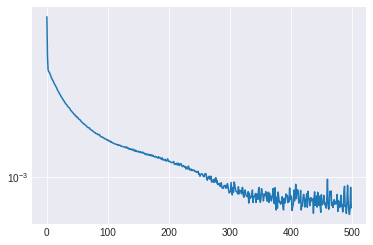

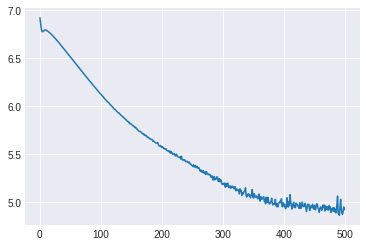

In [14]:
def maxent_fit(trajs,restraints):
    me_model = maxentep.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=1024,epochs=500)
    plt.plot(me_history.history['loss'])
    plt.yscale('log')
    plt.show()
    plt.plot(me_history.history['weight-entropy'])
    return me_model
me_model_1 = maxent_fit(trajs_1, restraints_1)

In [15]:
def compare_patches(ref_traj, trajs,weights_dict, method, restrained_patches,plot_fxns_list,
                    *args, figsize=(10, 6), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()


Plotting 10 patches in a 3 x 4 grid


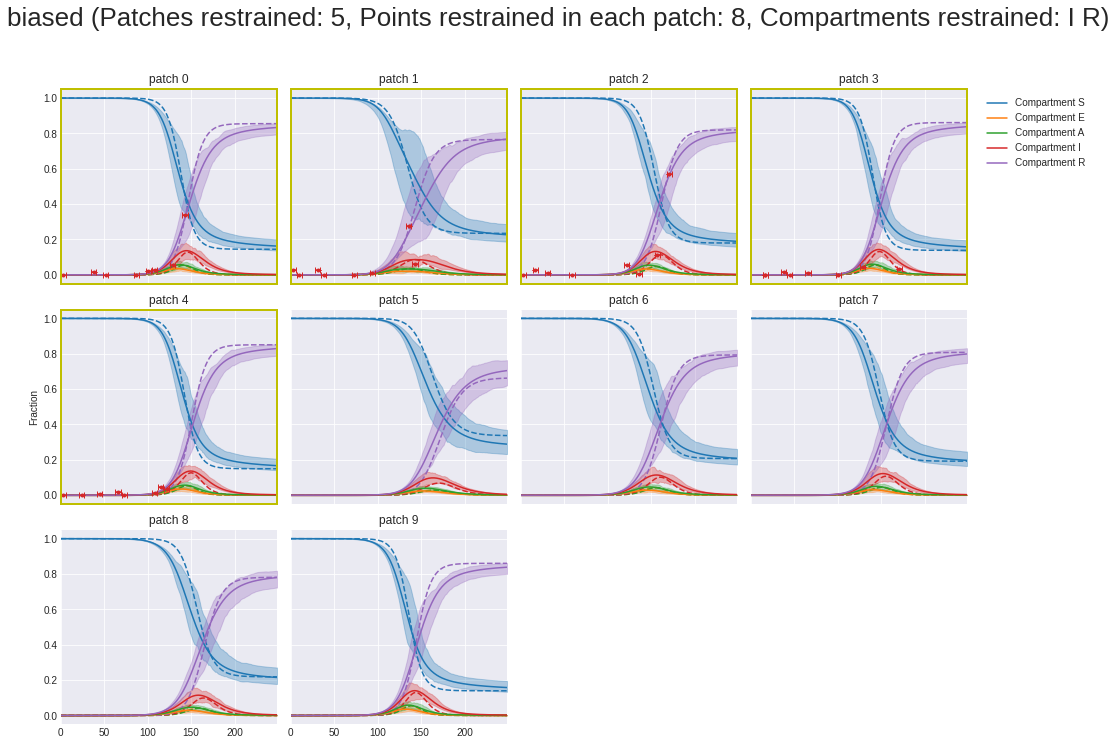

In [16]:
weights_dict_1 = {'unbiased':None, 'biased':me_model_1.traj_weights}
compare_patches(ref_traj_1, trajs_1, weights_dict_1,'biased', restrained_patches_1,plot_fxns_list_1,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

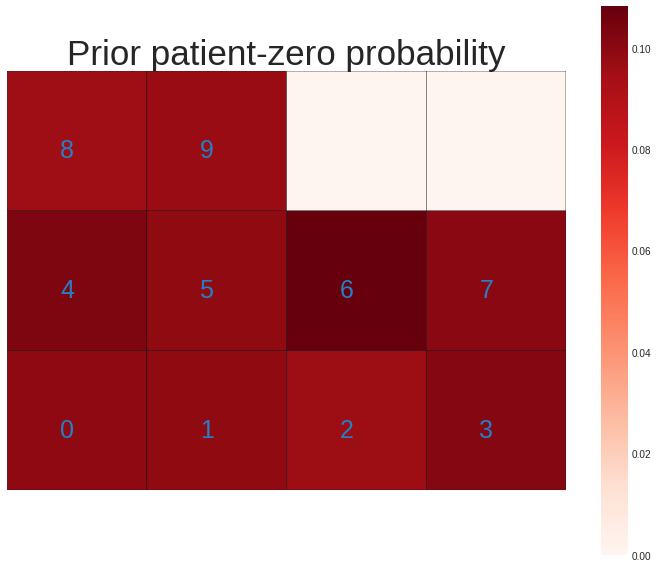

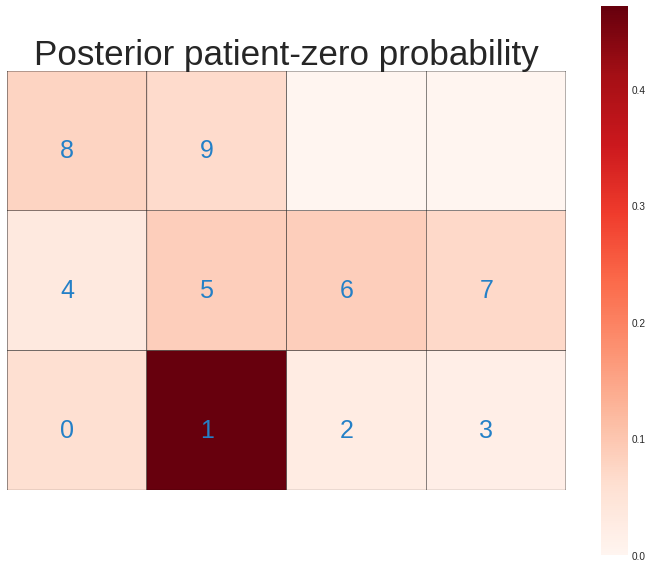

In [17]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
me_w_1 = me_model_1.traj_weights
maxentep.p0_map(prior_exposed_patch_1, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_1, M, weights = me_w_1, title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

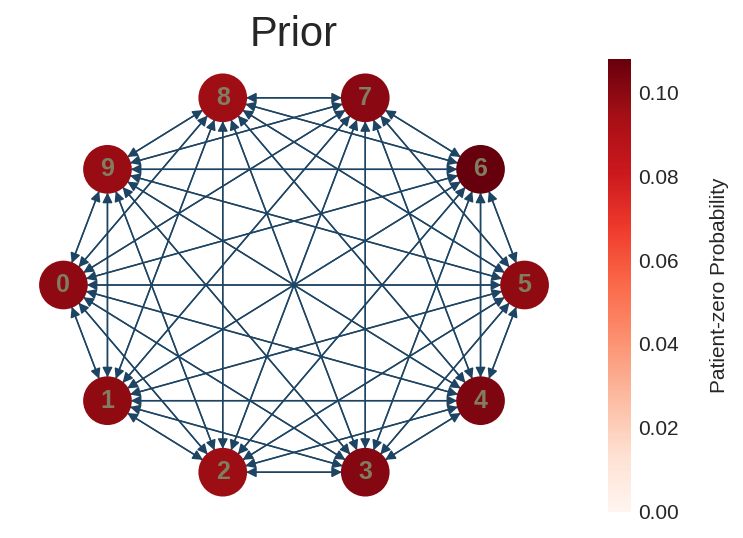

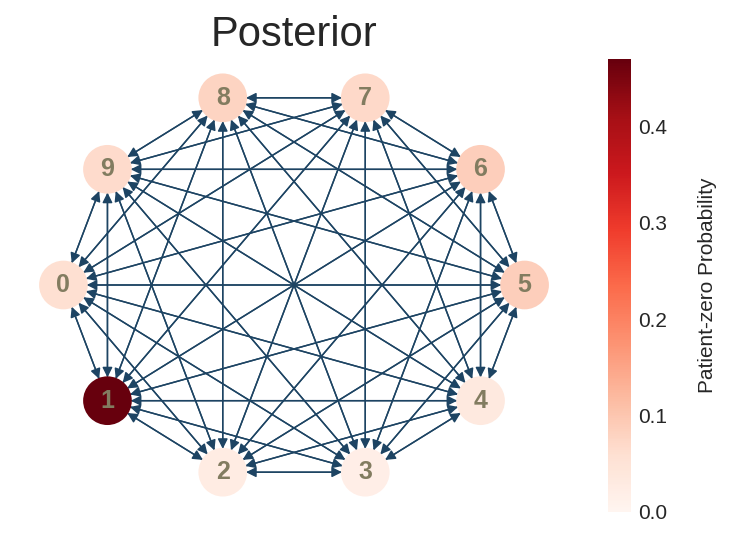

In [18]:
exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M)
weighted_exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M, weights=me_w_1)
maxentep.draw_graph(graph_1, weights=exposed_prob_1, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_1, weights=weighted_exposed_prob_1, title='Posterior', heatmap=True)

In [20]:
# posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_1, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.4708534496345973, 'patch 1'), (0.0875732567536925, 'patch 6'), (0.08693921987341995, 'patch 5'), (0.07883510514513228, 'patch 8'), (0.07035633056700637, 'patch 7')]


 # Case 2

6.9

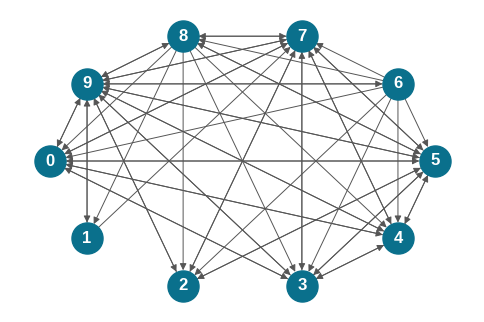

In [21]:
graph_2, edge_list_2, node_list_2 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)
graph_2.remove_edges_from([(1, i) for i in range(0,7) if i!=1])
graph_2.remove_edges_from([(i, 1) for i in range(0,8)  if i!=1])
graph_2.remove_edges_from([(2, i) for i in range(0,5) if i!=2])
graph_2.remove_edges_from([(i,2) for i in range(0,5)  if i!=2])
graph_2.remove_edges_from([(i,8) for i in range(0,5)  if i!=8])
graph_2.remove_edges_from([(i,6) for i in range(0,9)  if i!=6])
maxentep.draw_graph(graph_2, dpi=100)
# nx.draw(graph_2, with_labels=True, pos=nx.shell_layout(graph_2) , font_weight='bold', ax=ax, **options)
dof_2 = maxentep.graph_dof(graph_2.edges(), node_list_2)
dof_2

In [22]:
def sparse_graph_mobility(sparse_graph, fully_connected_mobility_matrix):
    R'''
    Generates a sprase mobility matrix based on a sparse graph and a fully connected mobility matrix inputs
    '''
    sparse_mobility_matrix = np.zeros_like(fully_connected_mobility_matrix)
    for i, edge in enumerate(sparse_graph.edges()):
        sparse_mobility_matrix[edge[0], edge[1]] = fully_connected_mobility_matrix[edge[0], edge[1]]
    return sparse_mobility_matrix


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


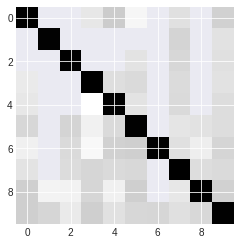

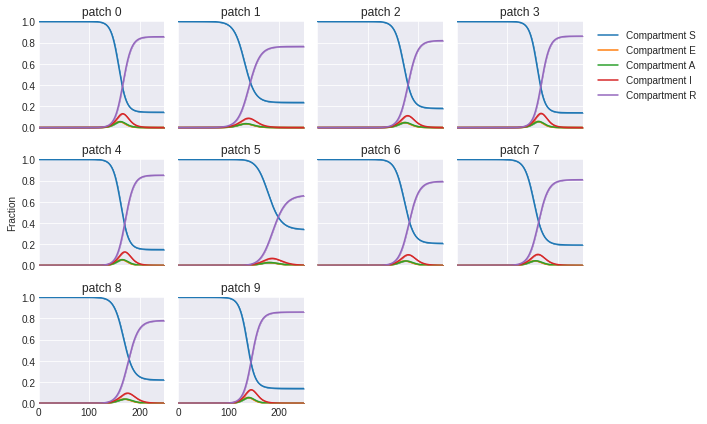

In [23]:
sparse_mobility_matrix_2 = sparse_graph_mobility(graph_2, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_2))
sparse_ref_traj_2 = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250,
                               population=population, area=area, mobility_matrix=sparse_mobility_matrix_2)
maxentep.patch_quantile(sparse_ref_traj_2, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [0, 180]
52 6.214542e-08 0.019260000372625593
45 2.070116e-08 0.031801347711679466
136 0.007008473 0.01935309752403884
115 0.00045135902 0.0
101 9.254579e-05 0.0
52 7.145146e-08 0.018865285950849756
171 0.41649976 0.43144353041128075
129 0.0040604314 0.0
52 3.284462e-07 0.0
66 1.7823077e-06 0.0
45 1.3770759e-07 0.0
80 9.344286e-06 0.0031434213913469943
108 0.00039950418 0.02294896177833409
143 0.022219371 0.07791803234706979
10 2.809025e-10 0.0
73 6.4237142e-06 0.0
136 0.0111413235 0.02878002256587417
157 0.094726905 0.09882716698108725
24 6.2239786e-10 0.02422727076760176
3 3.5515335e-13 0.0
136 0.016082983 0.03324146194984934
115 0.00096151046 0.023783547797700533
38 8.5346255e-09 0.029331582846109004
31 2.1895268e-09 0.017051040978751424
3 3.76237e-13 0.0
66 3.6977687e-07 0.01600632876367101
80 2.5390495e-06 0.0
122 0.00061349693 0.0
80 3.434006e-06 0.038616388392702816
24 3.608646e-10 0.003972130621981133
136 0.005265559 0.0023494140179460476


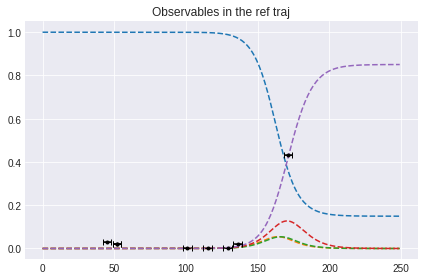

In [24]:
restraints_2, plot_fxns_list_2, restrained_patches_2 = gen_restraints(sparse_ref_traj_2)

100%|██████████| 16/16 [00:31<00:00,  2.00s/it]


Plotting 10 patches in a 3 x 4 grid


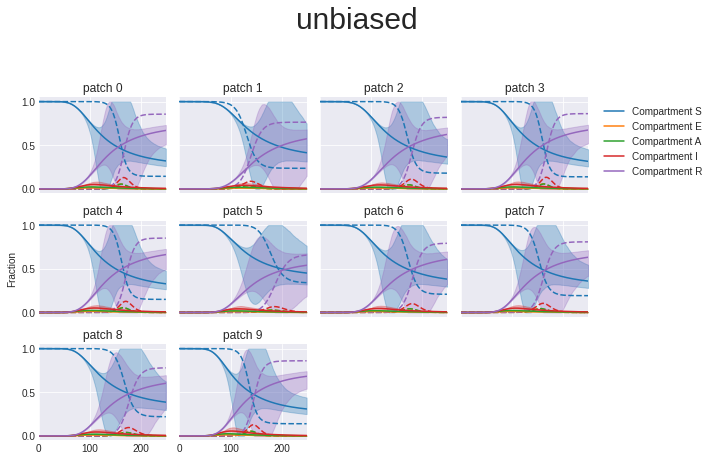

In [25]:
sparse_trajs_2 = gen_samples(sparse_mobility_matrix_2, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_2, sparse_trajs_2, weights=None, method='unbiased',
               patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0136 - weight-entropy: 6.9200
Epoch 2/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0065 - weight-entropy: 6.8614
Epoch 3/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0038 - weight-entropy: 6.7903
Epoch 4/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 6.7337
Epoch 5/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 6.6947
Epoch 6/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 6.6701
Epoch 7/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 6.6541
Epoch 8/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 6.6438
Epoch 9/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 6.6368
Epoch 10/500
8/8 [==============================] - 0s 1ms/step - loss: 0

8/8 [==============================] - 0s 972us/step - loss: 8.8484e-04 - weight-entropy: 6.3433
Epoch 79/500
8/8 [==============================] - 0s 973us/step - loss: 8.7367e-04 - weight-entropy: 6.3376
Epoch 80/500
8/8 [==============================] - 0s 995us/step - loss: 8.6168e-04 - weight-entropy: 6.3320
Epoch 81/500
8/8 [==============================] - 0s 957us/step - loss: 8.5627e-04 - weight-entropy: 6.3261
Epoch 82/500
8/8 [==============================] - 0s 988us/step - loss: 8.5437e-04 - weight-entropy: 6.3216
Epoch 83/500
8/8 [==============================] - 0s 972us/step - loss: 8.4674e-04 - weight-entropy: 6.3173
Epoch 84/500
8/8 [==============================] - 0s 971us/step - loss: 8.3543e-04 - weight-entropy: 6.3104
Epoch 85/500
8/8 [==============================] - 0s 1ms/step - loss: 8.2946e-04 - weight-entropy: 6.3049
Epoch 86/500
8/8 [==============================] - 0s 1ms/step - loss: 8.1788e-04 - weight-entropy: 6.2993
Epoch 87/500
8/8 [=========

8/8 [==============================] - 0s 1ms/step - loss: 5.2891e-04 - weight-entropy: 5.9791
Epoch 153/500
8/8 [==============================] - 0s 961us/step - loss: 5.2871e-04 - weight-entropy: 5.9778
Epoch 154/500
8/8 [==============================] - 0s 1ms/step - loss: 5.2094e-04 - weight-entropy: 5.9713
Epoch 155/500
8/8 [==============================] - 0s 1ms/step - loss: 5.2492e-04 - weight-entropy: 5.9663
Epoch 156/500
8/8 [==============================] - 0s 1ms/step - loss: 5.2738e-04 - weight-entropy: 5.9659
Epoch 157/500
8/8 [==============================] - 0s 987us/step - loss: 5.2358e-04 - weight-entropy: 5.9644
Epoch 158/500
8/8 [==============================] - 0s 985us/step - loss: 5.0619e-04 - weight-entropy: 5.9538
Epoch 159/500
8/8 [==============================] - 0s 965us/step - loss: 5.1913e-04 - weight-entropy: 5.9545
Epoch 160/500
8/8 [==============================] - 0s 997us/step - loss: 5.1650e-04 - weight-entropy: 5.9474
Epoch 161/500
8/8 [====

8/8 [==============================] - 0s 1ms/step - loss: 4.2367e-04 - weight-entropy: 5.7300
Epoch 227/500
8/8 [==============================] - 0s 1ms/step - loss: 4.0897e-04 - weight-entropy: 5.7262
Epoch 228/500
8/8 [==============================] - 0s 1ms/step - loss: 4.2213e-04 - weight-entropy: 5.7292
Epoch 229/500
8/8 [==============================] - 0s 992us/step - loss: 4.2337e-04 - weight-entropy: 5.7268
Epoch 230/500
8/8 [==============================] - 0s 1ms/step - loss: 4.1059e-04 - weight-entropy: 5.7116
Epoch 231/500
8/8 [==============================] - 0s 1ms/step - loss: 4.0915e-04 - weight-entropy: 5.7217
Epoch 232/500
8/8 [==============================] - 0s 1ms/step - loss: 4.0193e-04 - weight-entropy: 5.7111
Epoch 233/500
8/8 [==============================] - 0s 997us/step - loss: 4.1305e-04 - weight-entropy: 5.7205
Epoch 234/500
8/8 [==============================] - 0s 1ms/step - loss: 4.1999e-04 - weight-entropy: 5.7049
Epoch 235/500
8/8 [==========

8/8 [==============================] - 0s 1ms/step - loss: 3.6884e-04 - weight-entropy: 5.5680
Epoch 301/500
8/8 [==============================] - 0s 1ms/step - loss: 3.6138e-04 - weight-entropy: 5.5718
Epoch 302/500
8/8 [==============================] - 0s 984us/step - loss: 3.7364e-04 - weight-entropy: 5.5885
Epoch 303/500
8/8 [==============================] - 0s 993us/step - loss: 3.5358e-04 - weight-entropy: 5.5639
Epoch 304/500
8/8 [==============================] - 0s 948us/step - loss: 3.7212e-04 - weight-entropy: 5.5751
Epoch 305/500
8/8 [==============================] - 0s 941us/step - loss: 3.8959e-04 - weight-entropy: 5.5879
Epoch 306/500
8/8 [==============================] - 0s 976us/step - loss: 3.6128e-04 - weight-entropy: 5.5649
Epoch 307/500
8/8 [==============================] - 0s 969us/step - loss: 3.7147e-04 - weight-entropy: 5.5623
Epoch 308/500
8/8 [==============================] - 0s 980us/step - loss: 3.8450e-04 - weight-entropy: 5.5659
Epoch 309/500
8/8 [

8/8 [==============================] - 0s 984us/step - loss: 3.6734e-04 - weight-entropy: 5.4746
Epoch 375/500
8/8 [==============================] - 0s 986us/step - loss: 3.4067e-04 - weight-entropy: 5.4803
Epoch 376/500
8/8 [==============================] - 0s 951us/step - loss: 3.4022e-04 - weight-entropy: 5.4823
Epoch 377/500
8/8 [==============================] - 0s 982us/step - loss: 3.4750e-04 - weight-entropy: 5.4791
Epoch 378/500
8/8 [==============================] - 0s 957us/step - loss: 3.5690e-04 - weight-entropy: 5.4899
Epoch 379/500
8/8 [==============================] - 0s 1ms/step - loss: 3.4525e-04 - weight-entropy: 5.4667
Epoch 380/500
8/8 [==============================] - 0s 1ms/step - loss: 3.3061e-04 - weight-entropy: 5.4647
Epoch 381/500
8/8 [==============================] - 0s 947us/step - loss: 3.3814e-04 - weight-entropy: 5.4711
Epoch 382/500
8/8 [==============================] - 0s 986us/step - loss: 3.1903e-04 - weight-entropy: 5.4573
Epoch 383/500
8/8 [

8/8 [==============================] - 0s 1ms/step - loss: 3.3224e-04 - weight-entropy: 5.4155
Epoch 449/500
8/8 [==============================] - 0s 963us/step - loss: 3.1564e-04 - weight-entropy: 5.4031
Epoch 450/500
8/8 [==============================] - 0s 1ms/step - loss: 3.4557e-04 - weight-entropy: 5.4175
Epoch 451/500
8/8 [==============================] - 0s 1ms/step - loss: 3.3512e-04 - weight-entropy: 5.4164
Epoch 452/500
8/8 [==============================] - 0s 957us/step - loss: 3.2792e-04 - weight-entropy: 5.4144
Epoch 453/500
8/8 [==============================] - 0s 963us/step - loss: 3.2521e-04 - weight-entropy: 5.4216
Epoch 454/500
8/8 [==============================] - 0s 1ms/step - loss: 3.2717e-04 - weight-entropy: 5.4116
Epoch 455/500
8/8 [==============================] - 0s 960us/step - loss: 3.2069e-04 - weight-entropy: 5.4101
Epoch 456/500
8/8 [==============================] - 0s 1ms/step - loss: 3.2260e-04 - weight-entropy: 5.4185
Epoch 457/500
8/8 [======

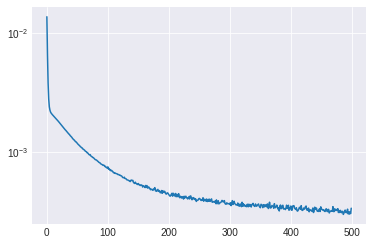

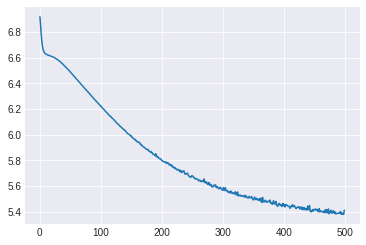

In [26]:
sparse_me_model_2 = maxent_fit(sparse_trajs_2, restraints_2)

Plotting 10 patches in a 3 x 4 grid


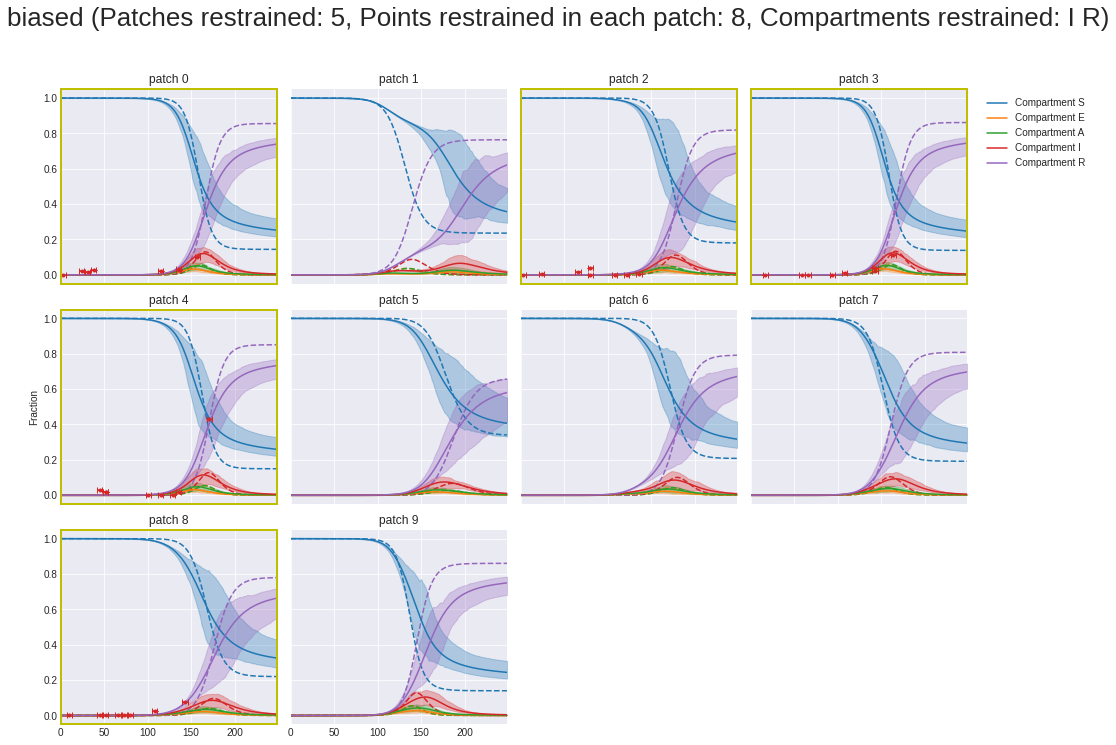

In [27]:
weights_dict_2 = {'unbiased':None, 'biased':sparse_me_model_2.traj_weights}
compare_patches(sparse_ref_traj_2, sparse_trajs_2, weights_dict_2,'biased', restrained_patches_2, plot_fxns_list_2,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

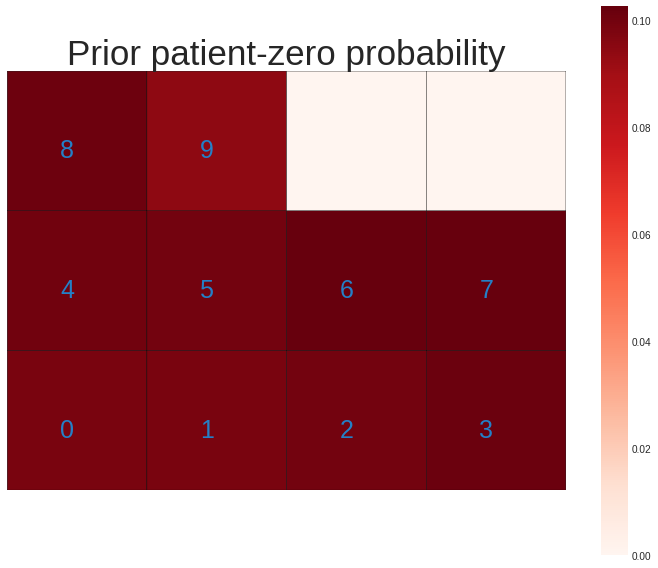

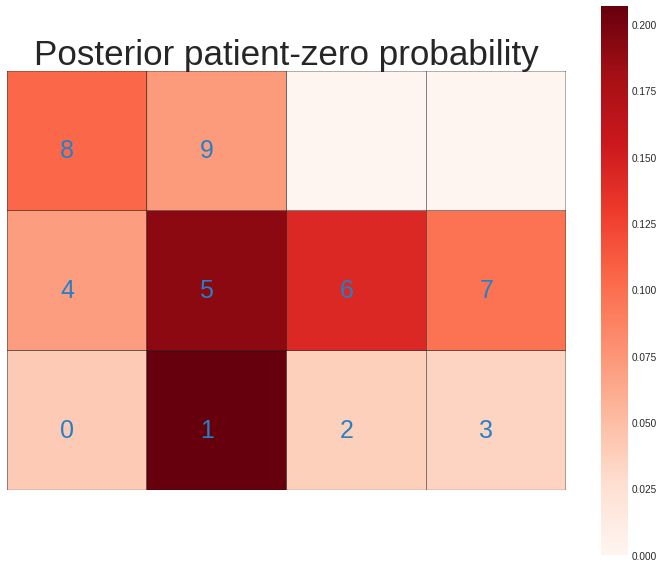

In [28]:
me_w_2 = sparse_me_model_2.traj_weights
prior_exposed_patch_2 = maxentep.exposed_finder(sparse_trajs_2)
maxentep.p0_map(prior_exposed_patch_2, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_2, M, weights = me_w_2, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

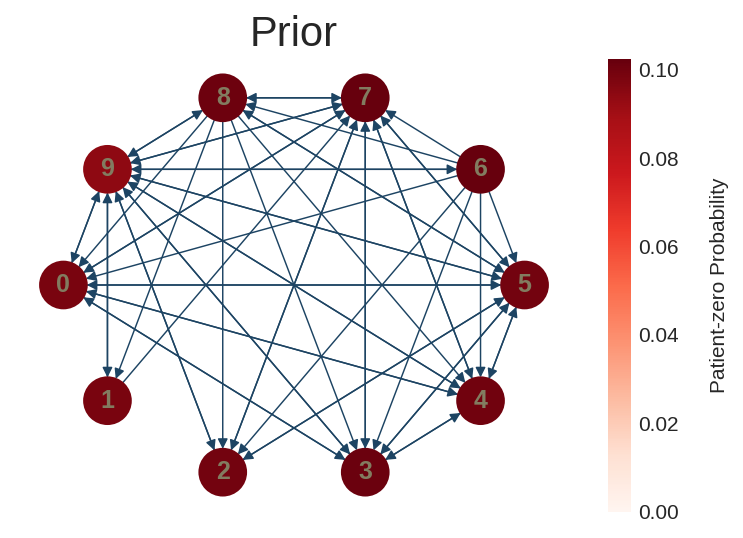

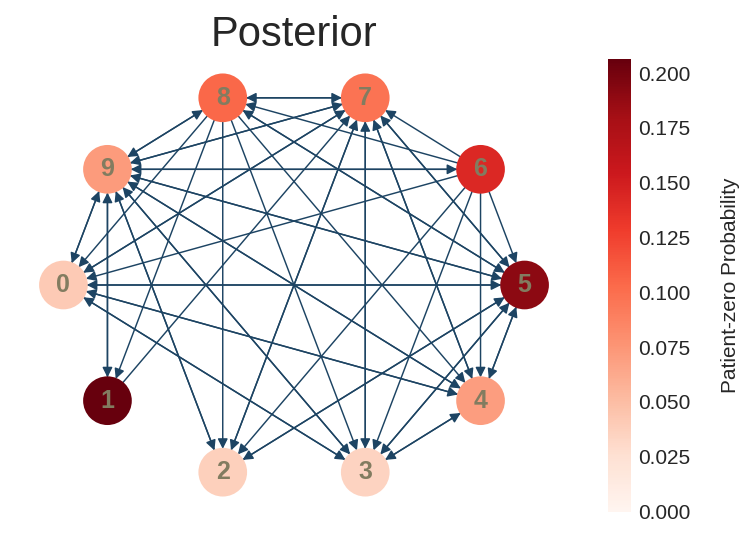

In [29]:
exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M)
weighted_exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M, weights=me_w_2)
maxentep.draw_graph(graph_2, weights=exposed_prob_2, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_2, weights=weighted_exposed_prob_2, title='Posterior', heatmap=True)

In [30]:
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_2, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.20671061593359175, 'patch 1'), (0.19124677617810804, 'patch 5'), (0.14355991297268797, 'patch 6'), (0.10445756997580832, 'patch 8'), (0.09689739355040788, 'patch 7')]


# Case 3

4.5

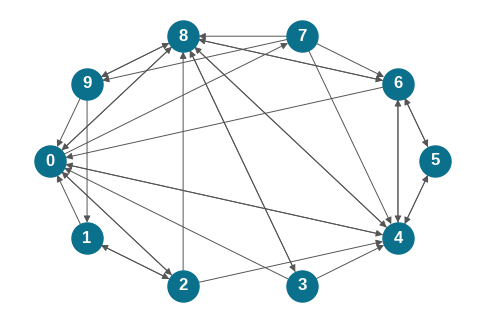

In [31]:
graph_3, edge_list_3, node_list_3 = maxentep.gen_graph(10)
graph_3.remove_edges_from([(1, i) for i in range(3,9)])
graph_3.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i != 1])
graph_3.remove_edges_from([(i, 2) for i in range(3,9) ])
graph_3.remove_edges_from([(i, 6) for i in range(0,4)])
graph_3.remove_edges_from([(i, 7) for i in range(1,10) if i != 7])
graph_3.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_3.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_3.remove_edges_from([(9,i) for i in range(2,8)])
graph_3.remove_edges_from([(i,9) for i in range(0,7)])
# graph.remove_edges_from([(i,4) for i in range(0,7)])
maxentep.draw_graph(graph_3,dpi=100)
dof_3 = maxentep.graph_dof(graph_3.edges(), node_list_3)
dof_3


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


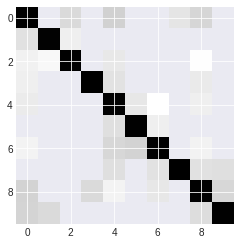

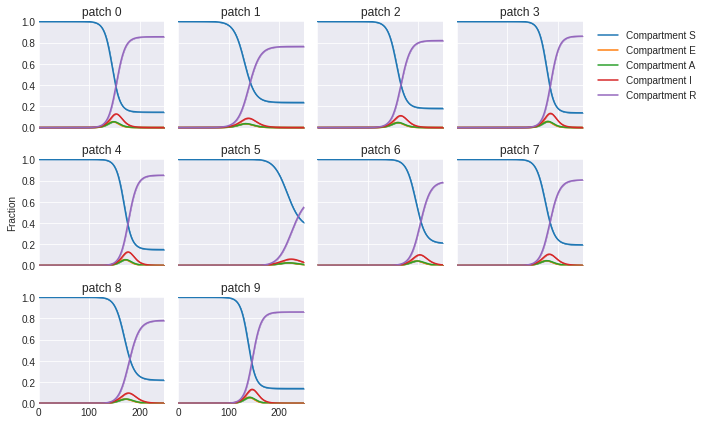

In [32]:
sparse_mobility_matrix_3 = sparse_graph_mobility(graph_3, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_3))
sparse_ref_traj_3 = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, population=population,
                               area=area, mobility_matrix=sparse_mobility_matrix_3)
maxentep.patch_quantile(sparse_ref_traj_3, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [0, 180]
31 1.321262e-05 0.0
94 0.004969317 0.0
136 0.084948264 0.11587317519449736
87 0.0026006713 0.005091604150500651
73 0.0014113749 0.055335855942448414
101 0.019469095 0.01799060206840701
24 1.1907549e-05 0.0
129 0.20239809 0.19211341223584194
115 2.4001035e-06 0.0
3 8.053299e-18 0.0
164 0.0014945598 0.0003958584632863648
59 6.354178e-10 0.0
73 6.725321e-09 0.0
31 2.8443788e-12 0.0006804484468209026
164 0.002279748 0.00887350081657473
129 2.2229762e-05 0.014116667617654996
73 1.2214883e-05 0.0
59 2.2343827e-06 0.0
164 0.10996986 0.10390328350333368
108 0.0007450321 0.0
94 0.0002336208 0.0
31 6.986163e-08 0.002994938318012755
143 0.06244028 0.06378126391878208
38 1.99486e-07 0.0
80 1.248758e-06 0.0007413631962563977
101 2.2174148e-05 0.015380222303052409
129 0.0008890358 0.012686632229597792
115 0.00014346492 0.0
24 1.0476291e-10 0.0
66 2.1078073e-07 0.035927012951993305
73 5.9358655e-07 0.0
108 7.849688e-05 0.0
80 1.4134296e-06 0.00401575081

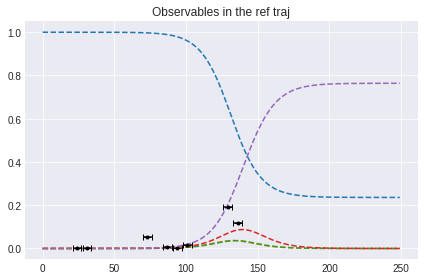

In [33]:
restraints_3, plot_fxns_list_3, restrained_patches_3 = gen_restraints(sparse_ref_traj_3)

100%|██████████| 16/16 [00:31<00:00,  1.97s/it]


Plotting 10 patches in a 3 x 4 grid


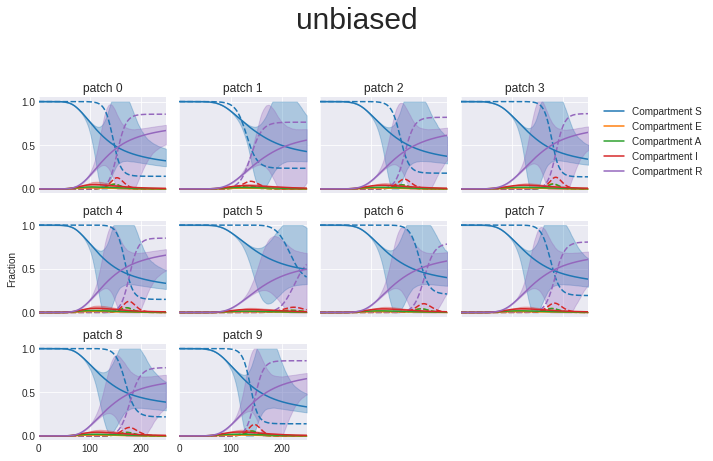

In [34]:
sparse_trajs_3 = gen_samples(sparse_mobility_matrix_3, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_3, sparse_trajs_3, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0077 - weight-entropy: 6.9251
Epoch 2/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0047 - weight-entropy: 6.8912
Epoch 3/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0033 - weight-entropy: 6.8483
Epoch 4/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 6.8091
Epoch 5/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 6.7779
Epoch 6/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 6.7539
Epoch 7/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 6.7347
Epoch 8/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 6.7192
Epoch 9/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 6.7059
Epoch 10/500
8/8 [==============================] - 0s 1ms/step - loss: 0

8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 6.5805
Epoch 80/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 6.5806
Epoch 81/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 6.5806
Epoch 82/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 6.5805
Epoch 83/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 6.5804
Epoch 84/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 6.5803
Epoch 85/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 6.5800
Epoch 86/500
8/8 [==============================] - 0s 28ms/step - loss: 0.0012 - weight-entropy: 6.5798
Epoch 87/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 6.5794
Epoch 88/500
8/8 [==============================] - 0s 1ms/step - loss: 0.00

8/8 [==============================] - 0s 1ms/step - loss: 6.2592e-04 - weight-entropy: 6.2394
Epoch 156/500
8/8 [==============================] - 0s 1ms/step - loss: 6.3119e-04 - weight-entropy: 6.2304
Epoch 157/500
8/8 [==============================] - 0s 1ms/step - loss: 6.1078e-04 - weight-entropy: 6.2176
Epoch 158/500
8/8 [==============================] - 0s 1ms/step - loss: 5.9367e-04 - weight-entropy: 6.2079
Epoch 159/500
8/8 [==============================] - 0s 1ms/step - loss: 5.9915e-04 - weight-entropy: 6.1977
Epoch 160/500
8/8 [==============================] - 0s 1ms/step - loss: 5.8515e-04 - weight-entropy: 6.1882
Epoch 161/500
8/8 [==============================] - 0s 1ms/step - loss: 5.9177e-04 - weight-entropy: 6.1787
Epoch 162/500
8/8 [==============================] - 0s 1ms/step - loss: 5.6362e-04 - weight-entropy: 6.1642
Epoch 163/500
8/8 [==============================] - 0s 1ms/step - loss: 5.6570e-04 - weight-entropy: 6.1528
Epoch 164/500
8/8 [==============

8/8 [==============================] - 0s 974us/step - loss: 3.3194e-04 - weight-entropy: 5.4789
Epoch 231/500
8/8 [==============================] - 0s 970us/step - loss: 3.3613e-04 - weight-entropy: 5.4872
Epoch 232/500
8/8 [==============================] - 0s 1ms/step - loss: 2.9635e-04 - weight-entropy: 5.4386
Epoch 233/500
8/8 [==============================] - 0s 971us/step - loss: 3.3337e-04 - weight-entropy: 5.4625
Epoch 234/500
8/8 [==============================] - 0s 992us/step - loss: 3.4594e-04 - weight-entropy: 5.4666
Epoch 235/500
8/8 [==============================] - 0s 1ms/step - loss: 3.3384e-04 - weight-entropy: 5.4318
Epoch 236/500
8/8 [==============================] - 0s 1ms/step - loss: 3.1724e-04 - weight-entropy: 5.4181
Epoch 237/500
8/8 [==============================] - 0s 1ms/step - loss: 3.2962e-04 - weight-entropy: 5.4336
Epoch 238/500
8/8 [==============================] - 0s 1ms/step - loss: 3.3090e-04 - weight-entropy: 5.4215
Epoch 239/500
8/8 [======

8/8 [==============================] - 0s 1ms/step - loss: 2.9024e-04 - weight-entropy: 5.2066
Epoch 305/500
8/8 [==============================] - 0s 980us/step - loss: 2.6772e-04 - weight-entropy: 5.1381
Epoch 306/500
8/8 [==============================] - 0s 1ms/step - loss: 3.3259e-04 - weight-entropy: 5.2201
Epoch 307/500
8/8 [==============================] - 0s 934us/step - loss: 3.0101e-04 - weight-entropy: 5.1882
Epoch 308/500
8/8 [==============================] - 0s 1ms/step - loss: 2.7007e-04 - weight-entropy: 5.1652
Epoch 309/500
8/8 [==============================] - 0s 1ms/step - loss: 3.0388e-04 - weight-entropy: 5.1671
Epoch 310/500
8/8 [==============================] - 0s 1ms/step - loss: 3.1057e-04 - weight-entropy: 5.1989
Epoch 311/500
8/8 [==============================] - 0s 1ms/step - loss: 3.0246e-04 - weight-entropy: 5.2209
Epoch 312/500
8/8 [==============================] - 0s 1ms/step - loss: 3.2782e-04 - weight-entropy: 5.2163
Epoch 313/500
8/8 [==========

8/8 [==============================] - 0s 1ms/step - loss: 3.4987e-04 - weight-entropy: 5.2269
Epoch 379/500
8/8 [==============================] - 0s 1ms/step - loss: 3.1378e-04 - weight-entropy: 5.1319
Epoch 380/500
8/8 [==============================] - 0s 1ms/step - loss: 3.6353e-04 - weight-entropy: 5.2550
Epoch 381/500
8/8 [==============================] - 0s 1ms/step - loss: 2.9203e-04 - weight-entropy: 5.1358
Epoch 382/500
8/8 [==============================] - 0s 1ms/step - loss: 3.4907e-04 - weight-entropy: 5.1956
Epoch 383/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8352e-04 - weight-entropy: 5.0796
Epoch 384/500
8/8 [==============================] - 0s 1ms/step - loss: 2.6944e-04 - weight-entropy: 5.1088
Epoch 385/500
8/8 [==============================] - 0s 996us/step - loss: 2.7436e-04 - weight-entropy: 5.0968
Epoch 386/500
8/8 [==============================] - 0s 1ms/step - loss: 2.9988e-04 - weight-entropy: 5.1461
Epoch 387/500
8/8 [============

8/8 [==============================] - 0s 990us/step - loss: 3.0962e-04 - weight-entropy: 5.0638
Epoch 453/500
8/8 [==============================] - 0s 1ms/step - loss: 2.7548e-04 - weight-entropy: 5.0555
Epoch 454/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8619e-04 - weight-entropy: 5.0302
Epoch 455/500
8/8 [==============================] - 0s 1ms/step - loss: 2.9840e-04 - weight-entropy: 5.0971
Epoch 456/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8382e-04 - weight-entropy: 5.0477
Epoch 457/500
8/8 [==============================] - 0s 1ms/step - loss: 3.0403e-04 - weight-entropy: 5.0818
Epoch 458/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8321e-04 - weight-entropy: 5.0723
Epoch 459/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8974e-04 - weight-entropy: 5.0787
Epoch 460/500
8/8 [==============================] - 0s 1ms/step - loss: 3.3352e-04 - weight-entropy: 5.0970
Epoch 461/500
8/8 [============

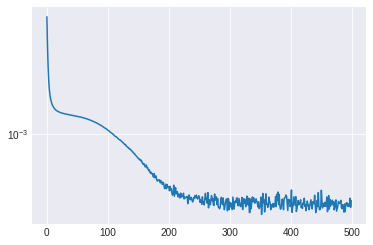

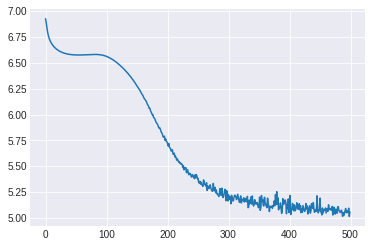

In [35]:
sparse_me_model_3 = maxent_fit(sparse_trajs_3, restraints_3)

Plotting 10 patches in a 3 x 4 grid


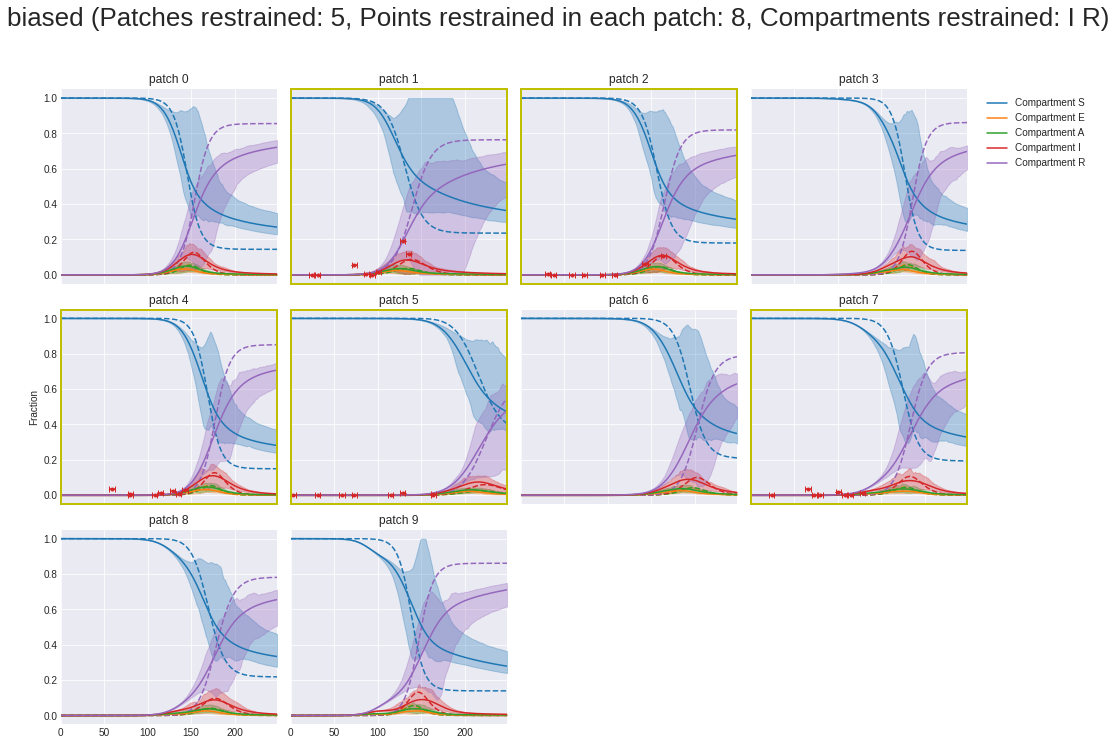

In [36]:
me_w_3 = sparse_me_model_3.traj_weights
weights_dict_3 = {'unbiased':None, 'biased':me_w_3}
compare_patches(sparse_ref_traj_3, sparse_trajs_3, weights_dict_3,'biased', restrained_patches_3, plot_fxns_list_3,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

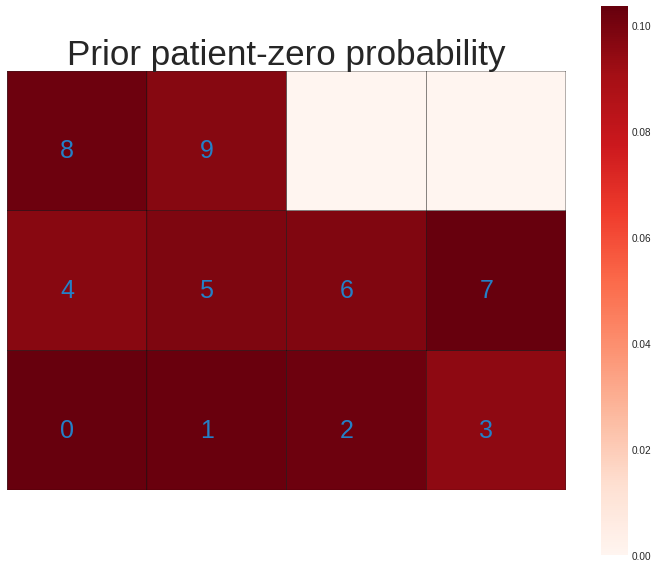

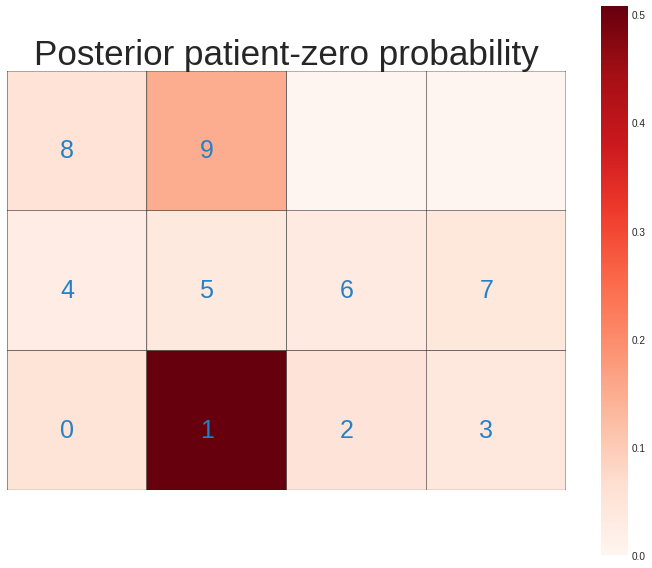

In [37]:
prior_exposed_patch_3 = maxentep.exposed_finder(sparse_trajs_3)
maxentep.p0_map(prior_exposed_patch_3, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_3, M, weights = me_w_3, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

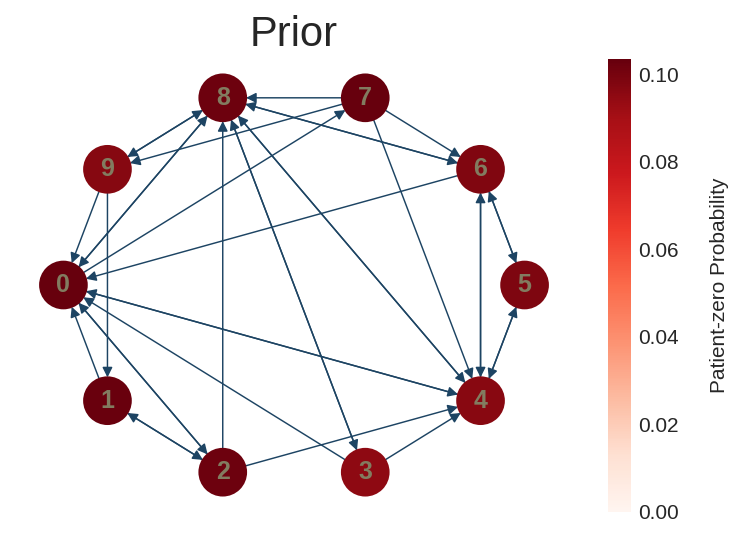

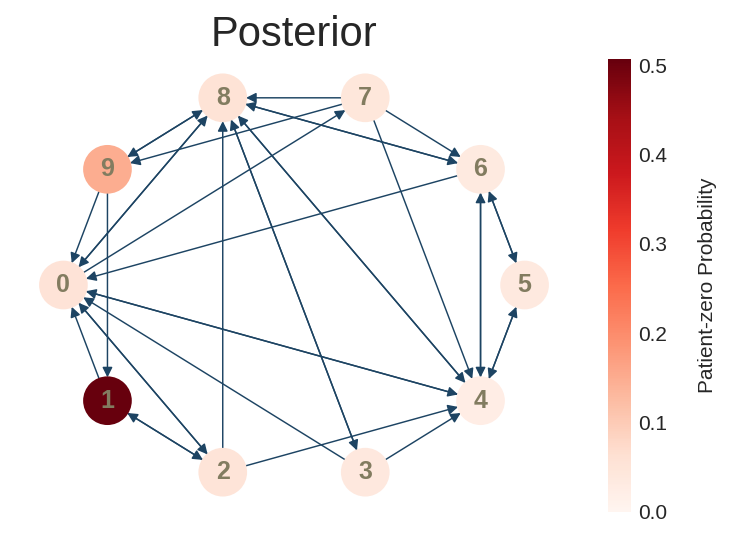

In [38]:
exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M)
weighted_exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M, weights=me_w_3)
maxentep.draw_graph(graph_3, weights=exposed_prob_3, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_3, weights=weighted_exposed_prob_3, title='Posterior', heatmap=True)

In [39]:
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_3, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.5076450297910242, 'patch 1'), (0.14913133862088515, 'patch 9'), (0.05628315027307708, 'patch 8'), (0.05502833804886295, 'patch 0'), (0.0531289572954695, 'patch 2')]


# Case 4

3.3

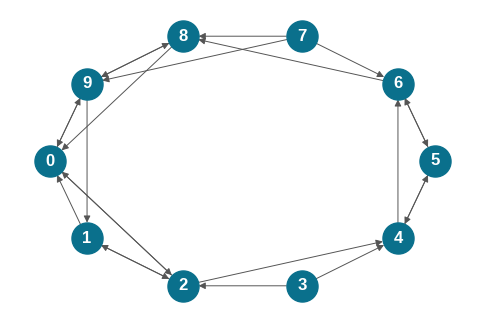

In [40]:
graph_4, edge_list_4, node_list_4 = maxentep.gen_graph(10)
graph_4.remove_edges_from([(1, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i!=1])
graph_4.remove_edges_from([(i, 2) for i in range(4,9)])
graph_4.remove_edges_from([(i, 6) for i in range(0,4)])
graph_4.remove_edges_from([(i, 7) for i in range(1,10) if i!=7])
graph_4.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_4.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5] )
graph_4.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_4.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_4.remove_edges_from([(9,i) for i in range(2,8)])
graph_4.remove_edges_from([(i,9) for i in range(1,7)])
graph_4.remove_edges_from([(0, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 0) for i in range(3,8)])
graph_4.remove_edges_from([(i, 8) for i in range(2,6)])
graph_4.remove_edges_from([(8, i) for i in range(1,8) if i!=7 and i!=8])
graph_4.remove_edges_from([(i, 4) for i in range(6,9)])
maxentep.draw_graph(graph_4, dpi=100)
dof_4 = maxentep.graph_dof(graph_4.edges(), node_list_4)
dof_4


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


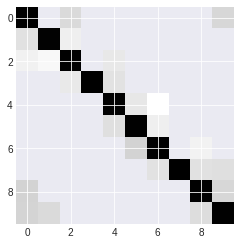

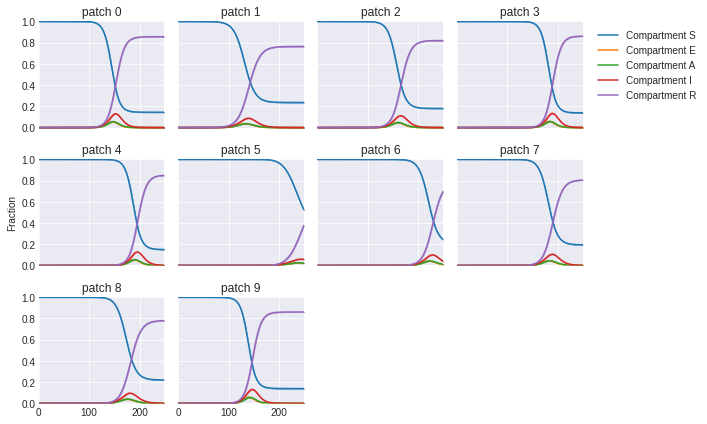

In [41]:
sparse_mobility_matrix_4 = sparse_graph_mobility(graph_4, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_4))
sparse_ref_traj_4 = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, population=population, area=area,
                                 mobility_matrix=sparse_mobility_matrix_4)
maxentep.patch_quantile(sparse_ref_traj_4, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])


Restraints are set in this time range: [0, 180]
73 1.216632e-05 0.020590876171617648
24 2.1071402e-08 0.0
45 3.835958e-07 0.0
171 0.09882544 0.1298703034117241
3 6.4674416e-12 0.0
94 0.00023259637 0.0066121438922354305
52 1.3424786e-06 0.05080240091596692
108 0.0012012477 0.0
66 1.6818272e-05 0.0
108 0.0039054581 0.0
45 9.833208e-07 0.022482624060561354
143 0.122741975 0.14725818155465972
143 0.30952594 0.2863782744485463
59 9.033359e-06 0.0
129 0.07703421 0.056990548234774674
87 0.0003769393 0.0
10 1.4282519e-15 0.010903400896386885
150 8.00589e-05 0.01587935516568002
80 5.1067857e-09 0.0039867926812303
115 7.56297e-07 0.0
45 1.627432e-11 0.0
24 1.2060341e-13 0.024866387689223703
101 1.3874248e-07 0.016253619584659686
108 3.7689372e-07 0.011745564481719862
171 0.047788747 0.024236167405334717
115 8.0518446e-05 0.0
164 0.026089933 0.061189655844378146
38 1.152581e-09 0.0
164 0.047593232 0.06339745757116003
45 3.95992e-09 0.002214541254413986
3 0.0 0.021558149521530307
94 6.4047185e-06 

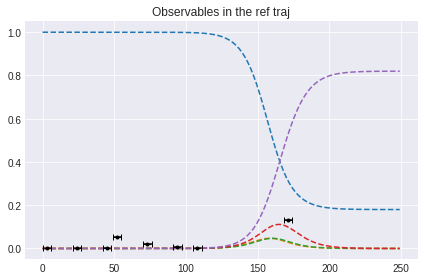

In [42]:
restraints_4, plot_fxns_list_4, restrained_patches_4 = gen_restraints(sparse_ref_traj_4)

100%|██████████| 16/16 [00:31<00:00,  1.96s/it]


Plotting 10 patches in a 3 x 4 grid


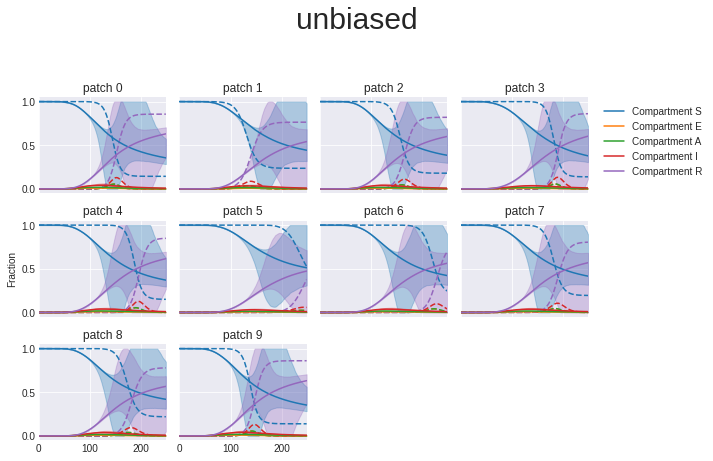

In [43]:
sparse_trajs_4 = gen_samples(sparse_mobility_matrix_4, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_4, sparse_trajs_4, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0063 - weight-entropy: 6.9254
Epoch 2/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0038 - weight-entropy: 6.8931
Epoch 3/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 6.8516
Epoch 4/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 6.8156
Epoch 5/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 6.7879
Epoch 6/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 6.7686
Epoch 7/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 6.7553
Epoch 8/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 6.7460
Epoch 9/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 6.7391
Epoch 10/500
8/8 [==============================] - 0s 1ms/step - loss: 0

8/8 [==============================] - 0s 964us/step - loss: 0.0010 - weight-entropy: 6.4823
Epoch 80/500
8/8 [==============================] - 0s 983us/step - loss: 0.0010 - weight-entropy: 6.4751
Epoch 81/500
8/8 [==============================] - 0s 997us/step - loss: 0.0010 - weight-entropy: 6.4678
Epoch 82/500
8/8 [==============================] - 0s 978us/step - loss: 0.0010 - weight-entropy: 6.4601
Epoch 83/500
8/8 [==============================] - 0s 1ms/step - loss: 9.9833e-04 - weight-entropy: 6.4530
Epoch 84/500
8/8 [==============================] - 0s 992us/step - loss: 9.9418e-04 - weight-entropy: 6.4453
Epoch 85/500
8/8 [==============================] - 0s 1000us/step - loss: 9.9011e-04 - weight-entropy: 6.4375
Epoch 86/500
8/8 [==============================] - 0s 1ms/step - loss: 9.7507e-04 - weight-entropy: 6.4286
Epoch 87/500
8/8 [==============================] - 0s 954us/step - loss: 9.6377e-04 - weight-entropy: 6.4215
Epoch 88/500
8/8 [========================

8/8 [==============================] - 0s 969us/step - loss: 5.5708e-04 - weight-entropy: 5.7605
Epoch 154/500
8/8 [==============================] - 0s 982us/step - loss: 5.7290e-04 - weight-entropy: 5.7659
Epoch 155/500
8/8 [==============================] - 0s 978us/step - loss: 5.3758e-04 - weight-entropy: 5.7250
Epoch 156/500
8/8 [==============================] - 0s 947us/step - loss: 5.3483e-04 - weight-entropy: 5.7317
Epoch 157/500
8/8 [==============================] - 0s 980us/step - loss: 5.3688e-04 - weight-entropy: 5.7228
Epoch 158/500
8/8 [==============================] - 0s 960us/step - loss: 5.3057e-04 - weight-entropy: 5.6954
Epoch 159/500
8/8 [==============================] - 0s 976us/step - loss: 5.1876e-04 - weight-entropy: 5.6841
Epoch 160/500
8/8 [==============================] - 0s 948us/step - loss: 5.0495e-04 - weight-entropy: 5.6675
Epoch 161/500
8/8 [==============================] - 0s 966us/step - loss: 5.0599e-04 - weight-entropy: 5.6597
Epoch 162/500
8

Epoch 227/500
8/8 [==============================] - 0s 975us/step - loss: 3.6273e-04 - weight-entropy: 4.9971
Epoch 228/500
8/8 [==============================] - 0s 974us/step - loss: 3.5899e-04 - weight-entropy: 4.9843
Epoch 229/500
8/8 [==============================] - 0s 997us/step - loss: 3.5205e-04 - weight-entropy: 5.0021
Epoch 230/500
8/8 [==============================] - 0s 1ms/step - loss: 3.3039e-04 - weight-entropy: 4.9264
Epoch 231/500
8/8 [==============================] - 0s 983us/step - loss: 3.2349e-04 - weight-entropy: 4.9153
Epoch 232/500
8/8 [==============================] - 0s 994us/step - loss: 3.5611e-04 - weight-entropy: 4.9429
Epoch 233/500
8/8 [==============================] - 0s 993us/step - loss: 3.2459e-04 - weight-entropy: 4.8850
Epoch 234/500
8/8 [==============================] - 0s 987us/step - loss: 3.7598e-04 - weight-entropy: 4.9826
Epoch 235/500
8/8 [==============================] - 0s 999us/step - loss: 3.5190e-04 - weight-entropy: 4.9374
Epo

8/8 [==============================] - 0s 929us/step - loss: 3.0112e-04 - weight-entropy: 4.5494
Epoch 302/500
8/8 [==============================] - 0s 925us/step - loss: 2.8691e-04 - weight-entropy: 4.5064
Epoch 303/500
8/8 [==============================] - 0s 911us/step - loss: 3.0916e-04 - weight-entropy: 4.5744
Epoch 304/500
8/8 [==============================] - 0s 1ms/step - loss: 3.1295e-04 - weight-entropy: 4.5649
Epoch 305/500
8/8 [==============================] - 0s 1ms/step - loss: 3.0451e-04 - weight-entropy: 4.5682
Epoch 306/500
8/8 [==============================] - 0s 1ms/step - loss: 3.0869e-04 - weight-entropy: 4.5501
Epoch 307/500
8/8 [==============================] - 0s 1ms/step - loss: 3.2544e-04 - weight-entropy: 4.5908
Epoch 308/500
8/8 [==============================] - 0s 1ms/step - loss: 3.0431e-04 - weight-entropy: 4.5002
Epoch 309/500
8/8 [==============================] - 0s 1ms/step - loss: 3.2941e-04 - weight-entropy: 4.5322
Epoch 310/500
8/8 [========

8/8 [==============================] - 0s 988us/step - loss: 2.8913e-04 - weight-entropy: 4.2886
Epoch 376/500
8/8 [==============================] - 0s 1ms/step - loss: 2.9064e-04 - weight-entropy: 4.3582
Epoch 377/500
8/8 [==============================] - 0s 1ms/step - loss: 3.1133e-04 - weight-entropy: 4.3039
Epoch 378/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8307e-04 - weight-entropy: 4.3011
Epoch 379/500
8/8 [==============================] - 0s 975us/step - loss: 3.2078e-04 - weight-entropy: 4.2964
Epoch 380/500
8/8 [==============================] - 0s 975us/step - loss: 2.8985e-04 - weight-entropy: 4.2833
Epoch 381/500
8/8 [==============================] - 0s 1ms/step - loss: 3.0318e-04 - weight-entropy: 4.3360
Epoch 382/500
8/8 [==============================] - 0s 1ms/step - loss: 3.1682e-04 - weight-entropy: 4.2924
Epoch 383/500
8/8 [==============================] - 0s 979us/step - loss: 3.0586e-04 - weight-entropy: 4.3096
Epoch 384/500
8/8 [======

8/8 [==============================] - 0s 997us/step - loss: 2.7858e-04 - weight-entropy: 4.1599
Epoch 450/500
8/8 [==============================] - 0s 1ms/step - loss: 2.6795e-04 - weight-entropy: 4.1555
Epoch 451/500
8/8 [==============================] - 0s 1ms/step - loss: 2.9485e-04 - weight-entropy: 4.1649
Epoch 452/500
8/8 [==============================] - 0s 960us/step - loss: 3.1620e-04 - weight-entropy: 4.2703
Epoch 453/500
8/8 [==============================] - 0s 990us/step - loss: 2.9344e-04 - weight-entropy: 4.2458
Epoch 454/500
8/8 [==============================] - 0s 976us/step - loss: 3.2127e-04 - weight-entropy: 4.2890
Epoch 455/500
8/8 [==============================] - 0s 1ms/step - loss: 3.0281e-04 - weight-entropy: 4.1944
Epoch 456/500
8/8 [==============================] - 0s 1ms/step - loss: 3.1825e-04 - weight-entropy: 4.3218
Epoch 457/500
8/8 [==============================] - 0s 1ms/step - loss: 2.6575e-04 - weight-entropy: 4.1382
Epoch 458/500
8/8 [======

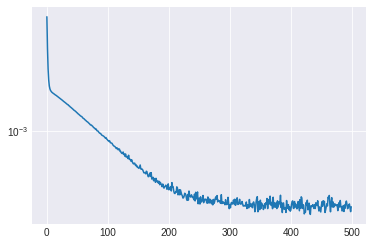

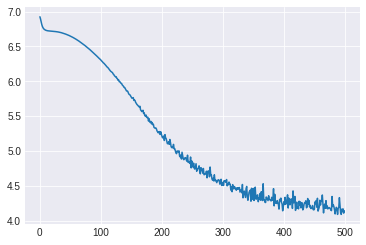

In [44]:
sparse_me_model_4 = maxent_fit(sparse_trajs_4, restraints_4)

Plotting 10 patches in a 3 x 4 grid


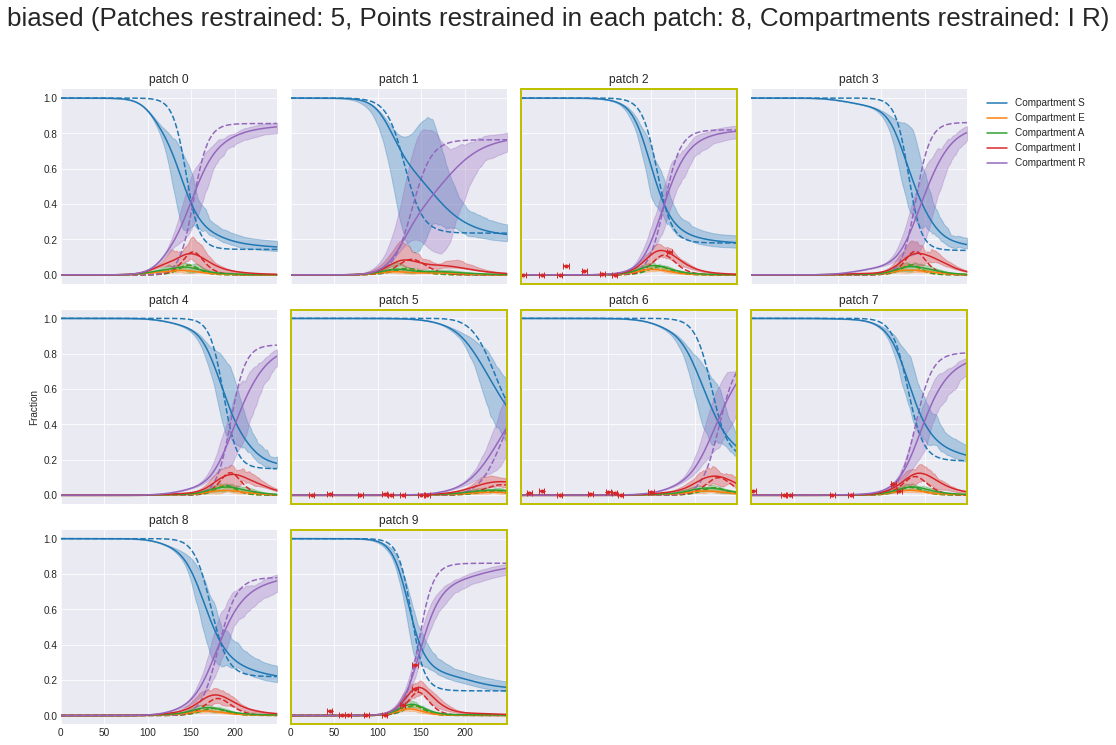

In [45]:
me_w_4 = sparse_me_model_4.traj_weights
weights_dict_4 = {'unbiased':None, 'biased':me_w_4}
compare_patches(sparse_ref_traj_4, sparse_trajs_4, weights_dict_4,'biased', restrained_patches_4, plot_fxns_list_4,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

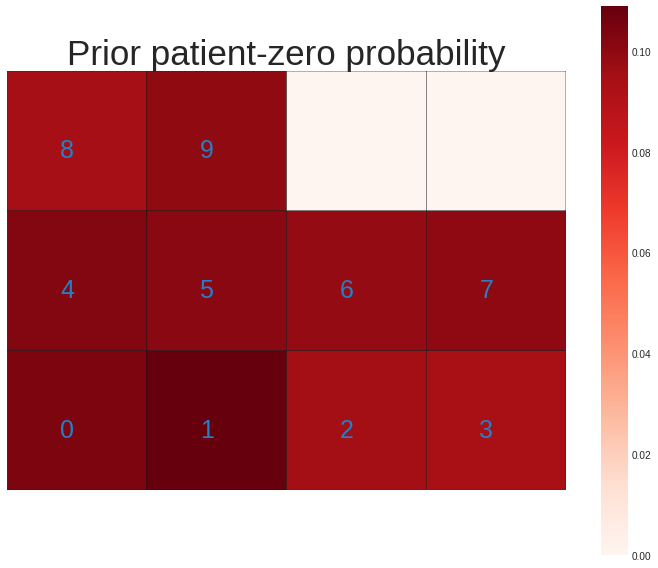

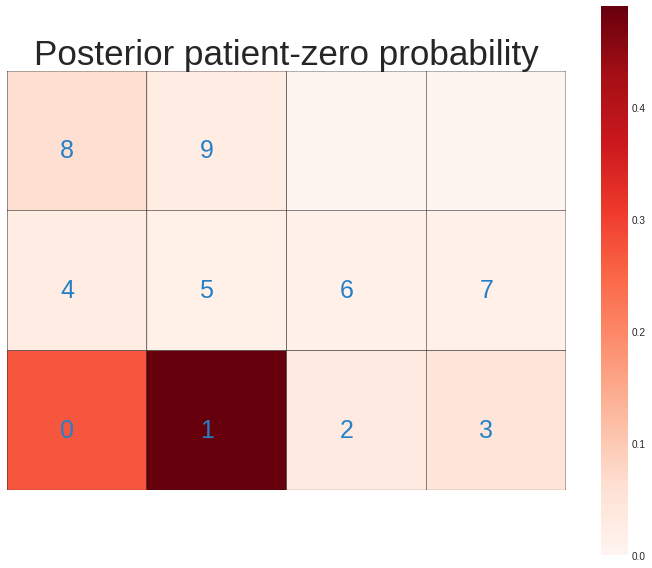

In [46]:
prior_exposed_patch_4 = maxentep.exposed_finder(sparse_trajs_4)
maxentep.p0_map(prior_exposed_patch_4, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_4, M, weights = me_w_4, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))


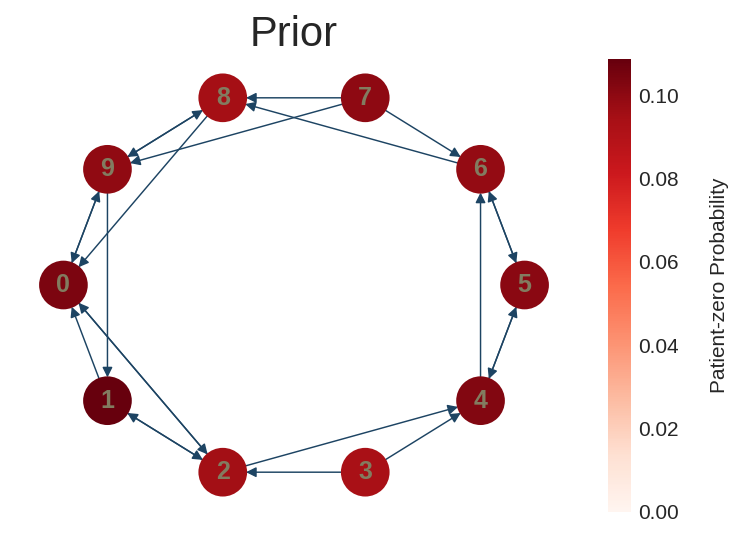

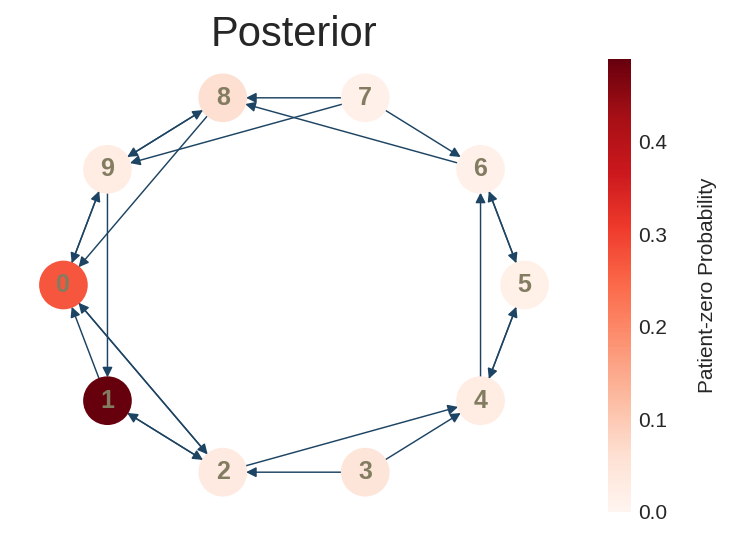

In [47]:
exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M)
weighted_exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M, weights=me_w_4)
maxentep.draw_graph(graph_4, weights=exposed_prob_4, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_4, weights=weighted_exposed_prob_4, title='Posterior', heatmap=True)

In [48]:
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_4, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.4899808269141431, 'patch 1'), (0.27087008492059866, 'patch 0'), (0.061425377978694067, 'patch 8'), (0.0467648042316803, 'patch 3'), (0.03323350776443695, 'patch 2')]


Text(0, 0.5, 'Certainty in the Origin of Patinet-zero ')

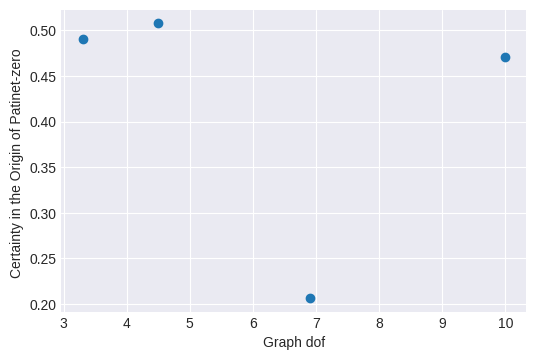

In [49]:
p0_probs = [max(weighted_exposed_prob_1),max(weighted_exposed_prob_2),max(weighted_exposed_prob_3),max(weighted_exposed_prob_4)]
dofs = [dof_1, dof_2, dof_3, dof_4]
fig, ax = plt.subplots(dpi=100)
plt.scatter(dofs,p0_probs)
ax.set_xlabel('Graph dof')
ax.set_ylabel('Certainty in the Origin of Patinet-zero ')